In [84]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from tqdm.auto import tqdm


%matplotlib inline

# Import Dataset

In [55]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv')

In [56]:
df

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11909,Acura,ZDX,2012,premium unleaded (required),300.0,6.0,AUTOMATIC,all wheel drive,4.0,"Crossover,Hatchback,Luxury",Midsize,4dr Hatchback,23,16,204,46120
11910,Acura,ZDX,2012,premium unleaded (required),300.0,6.0,AUTOMATIC,all wheel drive,4.0,"Crossover,Hatchback,Luxury",Midsize,4dr Hatchback,23,16,204,56670
11911,Acura,ZDX,2012,premium unleaded (required),300.0,6.0,AUTOMATIC,all wheel drive,4.0,"Crossover,Hatchback,Luxury",Midsize,4dr Hatchback,23,16,204,50620
11912,Acura,ZDX,2013,premium unleaded (recommended),300.0,6.0,AUTOMATIC,all wheel drive,4.0,"Crossover,Hatchback,Luxury",Midsize,4dr Hatchback,23,16,204,50920


## Preparing the dataset

In [57]:
subset_cols = [ 'Make',
                'Model',
                'Year',
                'Engine HP',
                'Engine Cylinders',
                'Transmission Type',
                'Vehicle Style',
                'highway MPG',
                'city mpg',
                'MSRP']

In [58]:
subset = df[subset_cols]

In [59]:
subset.columns = subset.columns.str.replace(' ', '_').str.lower()
subset = subset.rename(columns={'msrp': 'price'})
subset

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,price
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500
...,...,...,...,...,...,...,...,...,...,...
11909,Acura,ZDX,2012,300.0,6.0,AUTOMATIC,4dr Hatchback,23,16,46120
11910,Acura,ZDX,2012,300.0,6.0,AUTOMATIC,4dr Hatchback,23,16,56670
11911,Acura,ZDX,2012,300.0,6.0,AUTOMATIC,4dr Hatchback,23,16,50620
11912,Acura,ZDX,2013,300.0,6.0,AUTOMATIC,4dr Hatchback,23,16,50920


In [60]:
subset.isna().sum()

make                  0
model                 0
year                  0
engine_hp            69
engine_cylinders     30
transmission_type     0
vehicle_style         0
highway_mpg           0
city_mpg              0
price                 0
dtype: int64

In [61]:
subset = subset.fillna(0)
subset.isna().sum()

make                 0
model                0
year                 0
engine_hp            0
engine_cylinders     0
transmission_type    0
vehicle_style        0
highway_mpg          0
city_mpg             0
price                0
dtype: int64

In [62]:
subset['above_average'] = (subset.price > subset.price.mean()).astype(int)
subset

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,price,above_average
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135,1
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650,1
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350,0
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450,0
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500,0
...,...,...,...,...,...,...,...,...,...,...,...
11909,Acura,ZDX,2012,300.0,6.0,AUTOMATIC,4dr Hatchback,23,16,46120,1
11910,Acura,ZDX,2012,300.0,6.0,AUTOMATIC,4dr Hatchback,23,16,56670,1
11911,Acura,ZDX,2012,300.0,6.0,AUTOMATIC,4dr Hatchback,23,16,50620,1
11912,Acura,ZDX,2013,300.0,6.0,AUTOMATIC,4dr Hatchback,23,16,50920,1


## Split the data

In [63]:
df_features = subset.drop(['price', 'above_average'], axis=1)
df_target = subset['above_average']

In [64]:
feature_full_train, feature_test, target_full_train, target_test = train_test_split(df_features, df_target, random_state=1, test_size=0.2)
feature_train, feature_val, target_train, target_val = train_test_split(feature_full_train, target_full_train, random_state=1, test_size=0.25)

print(*(len(i) for i in [feature_train, target_train, feature_val, target_val, feature_test, target_test]))

7148 7148 2383 2383 2383 2383


In [65]:
feature_train

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg
5727,Toyota,Highlander Hybrid,2016,280.0,6.0,AUTOMATIC,4dr SUV,28,27
5814,Chevrolet,Impala Limited,2014,300.0,6.0,AUTOMATIC,Sedan,30,18
8450,Buick,Regal,2016,259.0,4.0,AUTOMATIC,Sedan,27,19
2396,Volkswagen,CC,2015,280.0,6.0,AUTOMATED_MANUAL,Sedan,25,17
5494,Dodge,Grand Caravan,2016,283.0,6.0,AUTOMATIC,Passenger Minivan,25,17
...,...,...,...,...,...,...,...,...,...
5864,Subaru,Impreza,2015,148.0,4.0,MANUAL,4dr Hatchback,33,24
7924,Infiniti,QX50,2016,325.0,6.0,AUTOMATIC,4dr SUV,24,17
4719,Honda,Fit,2017,130.0,4.0,AUTOMATIC,4dr Hatchback,37,32
63,Audi,200,1991,162.0,5.0,AUTOMATIC,Sedan,20,16


In [66]:
for x in [feature_train, target_train, feature_val, target_val, feature_test, target_test]:
    x.reset_index(drop=True, inplace=True)
feature_train

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg
0,Toyota,Highlander Hybrid,2016,280.0,6.0,AUTOMATIC,4dr SUV,28,27
1,Chevrolet,Impala Limited,2014,300.0,6.0,AUTOMATIC,Sedan,30,18
2,Buick,Regal,2016,259.0,4.0,AUTOMATIC,Sedan,27,19
3,Volkswagen,CC,2015,280.0,6.0,AUTOMATED_MANUAL,Sedan,25,17
4,Dodge,Grand Caravan,2016,283.0,6.0,AUTOMATIC,Passenger Minivan,25,17
...,...,...,...,...,...,...,...,...,...
7143,Subaru,Impreza,2015,148.0,4.0,MANUAL,4dr Hatchback,33,24
7144,Infiniti,QX50,2016,325.0,6.0,AUTOMATIC,4dr SUV,24,17
7145,Honda,Fit,2017,130.0,4.0,AUTOMATIC,4dr Hatchback,37,32
7146,Audi,200,1991,162.0,5.0,AUTOMATIC,Sedan,20,16


### Numeric & Categorical

In [67]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   make               11914 non-null  object 
 1   model              11914 non-null  object 
 2   year               11914 non-null  int64  
 3   engine_hp          11914 non-null  float64
 4   engine_cylinders   11914 non-null  float64
 5   transmission_type  11914 non-null  object 
 6   vehicle_style      11914 non-null  object 
 7   highway_mpg        11914 non-null  int64  
 8   city_mpg           11914 non-null  int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 837.8+ KB


In [68]:
categorical = list(df_features.dtypes[df_features.dtypes == 'object'].index)
categorical

['make', 'model', 'transmission_type', 'vehicle_style']

In [69]:
numerical = list(df_features.dtypes[df_features.dtypes != 'object'].index)
numerical

['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']

### Question 1

Let's do that

* For each numerical variable, use it as score and compute AUC with the above_average variable
* Use the training dataset for that

In [70]:
(feature_train.year > feature_train.year.mean()).astype(int)

0       1
1       1
2       1
3       1
4       1
       ..
7143    1
7144    1
7145    1
7146    0
7147    0
Name: year, Length: 7148, dtype: int32

In [97]:
dict_auc = {}
for col in numerical:
    auc = roc_auc_score(target_train, feature_train[col])
    dict_auc[col] = auc.round(3)
    if auc < 0.5:
        auc = roc_auc_score(target_train, -(feature_train[col]))
        dict_auc[col] = auc.round(3)
    
dict_auc

{'year': 0.688,
 'engine_hp': 0.917,
 'engine_cylinders': 0.766,
 'highway_mpg': 0.633,
 'city_mpg': 0.673}

Answer: engine_hp

### Question 2

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
What's the AUC of this model on the validation dataset? (round to 3 digits)

#### OHE

In [91]:
def vectorize(df_train, df_val):
    dv = DictVectorizer(sparse=False)

    train_dict = df_train.to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)


    val_dict = df_val.to_dict(orient='records')
    X_val = dv.transform(val_dict)

    return X_train, X_val

In [92]:
X_train, X_val = vectorize(feature_train, feature_val)

#### Linear Regression

In [73]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=1)

In [74]:
model.fit(X_train, target_train)

LogisticRegression(max_iter=1000, random_state=1, solver='liblinear')

In [75]:
y_pred = model.predict_proba(X_val)[:, 1]
y_pred

array([0.61076991, 0.02045705, 0.49098366, ..., 0.00663424, 0.99998347,
       0.0844014 ])

In [76]:
pred_above_avg = y_pred >= 0.5

In [94]:
roc_auc_score(target_val, y_pred).round(3)

0.976

Answer: 0.976

### Question 3

Now let's compute precision and recall for our model.
* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?


In [78]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
    df_scores['recall'] = df_scores['tpr']
    
    return df_scores

In [79]:
df_score = tpr_fpr_dataframe(target_val, y_pred)
df_score

,threshold,tp,fp,fn,tn,tpr,fpr,precision,recall
0,0.00,654,1729,0,0,1.000000,1.000000,0.274444,1.000000
1,0.01,652,854,2,875,0.996942,0.493927,0.432935,0.996942
2,0.02,651,702,3,1027,0.995413,0.406015,0.481153,0.995413
3,0.03,651,618,3,1111,0.995413,0.357432,0.513002,0.995413
4,0.04,650,559,4,1170,0.993884,0.323308,0.537634,0.993884
...,...,...,...,...,...,...,...,...,...
96,0.96,254,1,400,1728,0.388379,0.000578,0.996078,0.388379
97,0.97,241,0,413,1729,0.368502,0.000000,1.000000,0.368502
98,0.98,217,0,437,1729,0.331804,0.000000,1.000000,0.331804
99,0.99,184,0,470,1729,0.281346,0.000000,1.000000,0.281346


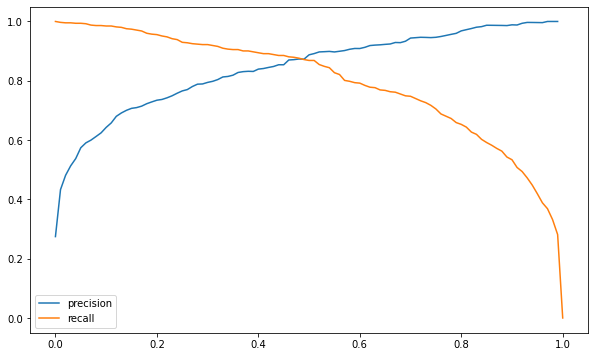

In [80]:
plt.figure(figsize=(10, 6))
plt.plot(df_score.threshold, df_score.precision, label='precision');
plt.plot(df_score.threshold, df_score.recall, label='recall');
plt.legend()

Answer: 0.48

### Question 4

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

In [81]:
df_score['f1'] = 2 * df_score.precision * df_score.recall / (df_score.precision + df_score.recall)
df_score[df_score.threshold.isin([0.12, 0.32, 0.52, 0.72])].sort_values(by='f1', ascending=False)

,threshold,tp,fp,fn,tn,tpr,fpr,precision,recall,f1
52,0.52,559,64,95,1665,0.854740,0.037016,0.897271,0.854740,0.875489
32,0.32,599,146,55,1583,0.915902,0.084442,0.804027,0.915902,0.856326
72,0.72,479,27,175,1702,0.732416,0.015616,0.946640,0.732416,0.825862
12,0.12,642,302,12,1427,0.981651,0.174667,0.680085,0.981651,0.803504


In [82]:
df_score.sort_values(by='f1', ascending=False)

,threshold,tp,fp,fn,tn,tpr,fpr,precision,recall,f1
51,0.51,568,69,86,1660,0.868502,0.039907,0.891680,0.868502,0.879938
50,0.50,568,72,86,1657,0.868502,0.041643,0.887500,0.868502,0.877898
52,0.52,559,64,95,1665,0.854740,0.037016,0.897271,0.854740,0.875489
46,0.46,576,86,78,1643,0.880734,0.049740,0.870091,0.880734,0.875380
47,0.47,575,85,79,1644,0.879205,0.049161,0.871212,0.879205,0.875190
...,...,...,...,...,...,...,...,...,...,...
97,0.97,241,0,413,1729,0.368502,0.000000,1.000000,0.368502,0.538547
98,0.98,217,0,437,1729,0.331804,0.000000,1.000000,0.331804,0.498278
99,0.99,184,0,470,1729,0.281346,0.000000,1.000000,0.281346,0.439141
0,0.00,654,1729,0,0,1.000000,1.000000,0.274444,1.000000,0.430688


Answer: 0.52

### Question 5


Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds: `KFold(n_splits=5, shuffle=True, random_state=1)`

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard devidation of the scores across different folds?

In [103]:
def LR_cross_val_score(feature_full_train, target_full_train, n_splits=5, random_state=1, C=1.0, max_iter=1000):
    
    kfold = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)

    scores = []

    for train_idx, val_idx in kfold.split(feature_full_train, target_full_train):
        df_train = feature_full_train.iloc[train_idx]
        df_val = feature_full_train.iloc[val_idx]

        y_train = target_full_train.iloc[train_idx]
        y_val = target_full_train.iloc[val_idx]

        X_train, X_val = vectorize(df_train, df_val)
        model = LogisticRegression(solver='liblinear', C=C, max_iter=max_iter)
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_val)[:, 1]

        auc = roc_auc_score(y_val, y_pred)
        
        scores.append(auc)
        
    return scores
    
scores = LR_cross_val_score(feature_full_train, target_full_train)
print(f'Mean roc_auc_score = {np.mean(scores):.2f}, standard devidation = {np.std(scores):.3f}')

Mean roc_auc_score = 0.98, standard devidation = 0.002


Answer: 0.002

### Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: [0.01, 0.1, 0.5, 10]
* Initialize KFold with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

In [105]:
for C in [0.01, 0.1, 0.5, 10]:
    scores = LR_cross_val_score(feature_full_train, target_full_train, C=C)
    print(f'With C = {C} mean roc_auc_score = {np.mean(scores):.3f}, standard devidation = {np.std(scores):.3f}')

With C = 0.01 mean roc_auc_score = 0.952, standard devidation = 0.003
With C = 0.1 mean roc_auc_score = 0.972, standard devidation = 0.002
With C = 0.5 mean roc_auc_score = 0.978, standard devidation = 0.003
With C = 10 mean roc_auc_score = 0.982, standard devidation = 0.002


Answer: C = 10